In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
# lets import some stuff
import numpy as np
import pandas as pd

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.initializers import Constant
from keras.models import Model
from keras.layers import *
from keras.utils.np_utils import to_categorical
import re
from keras import regularizers
import matplotlib.pyplot as plt
import os
%matplotlib inline
from keras.callbacks import EarlyStopping
from keras.models import Sequential
from keras import layers
from matplotlib import*
from plot_keras_history import show_history, plot_history
import seaborn as sns
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import RandomizedSearchCV

In [3]:
# confirm the GPU
from torch import cuda
assert cuda.is_available()
assert cuda.device_count() > 0
print(cuda.get_device_name(cuda.current_device()))

NVIDIA GeForce RTX 2060


In [4]:
max_features = 10000 # this is the number of words we care about

In [5]:
# read training dataset without rule based feature

filepath_dict = {
                 'train3':   r'C:\Users\nitis\Sentence classification\theis_final\preprocessed_train.csv'
                }

df_list = []
for source, filepath in filepath_dict.items():
    df = pd.read_csv(filepath, index_col=0)
    df['source'] = source  # Add another column filled with the source name
    df_list.append(df)

df = pd.concat(df_list)
print(df.iloc[0])

sentence              This live defined as 1 00 Defination
section_nr                                               1
has_citation                                           0.0
last_section_title                              Defination
Labels                                          Defination
source                                              train3
Name: 0, dtype: object


In [6]:
embedding_dim = 200

In [7]:
df['l'] = df['sentence'].apply(lambda x: len(str(x).split(' ')))
print("mean length of sentence: " + str(df.l.mean()))
print("max length of sentence: " + str(df.l.max()))
print("std dev length of sentence: " + str(df.l.std()))

mean length of sentence: 25.96232650363516
max length of sentence: 141
std dev length of sentence: 15.493430580410944


In [8]:
sequence_length = 141

In [9]:
#get test data without rule based features
cols = ['sentence', 'section_nr','has_citation','last_section_title','Labels']
cols1 = ['sentence', 'section_nr','has_citation','last_section_title']
test = pd.read_csv(r'C:\Users\nitis\Sentence classification\theis_final\preprocessed_test.csv')
test = test[cols]
test

,sentence,section_nr,has_citation,last_section_title,Labels
0,The aim of this thesis was to gain an understa...,1,0,Research Aim,Aim
1,The aim is to develop finite element models us...,1,0,Research Objective,Aim
2,Determine the relationship between the size of...,1,0,Research Objective,Aim
3,Investigate the influence of nonuniform cup su...,1,0,Research Objective,Aim
4,Examine the influence of errors during reaming...,1,0,Research Objective,Aim
...,...,...,...,...,...
577,the moment of enjoyment on the pattern to rais...,39,0,hypothesis outcome,Hypothesis Result
578,Information technology substantiate the hypoth...,10,0,hypothesis outcome,Hypothesis Result
579,information engineering science rejects the su...,10,0,hypothesis outcome,Hypothesis Result
580,the supposition stern follow agreed on the cor...,10,0,hypothesis outcome,Hypothesis Result


In [10]:
sentences_train = df["sentence"].values
sentences_test = test["sentence"].values

y_train =  pd.get_dummies(df['Labels']).values
y_test  = pd.get_dummies(test['Labels']).values


In [11]:
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(sentences_train)

X_train = tokenizer.texts_to_sequences(sentences_train)
X_test = tokenizer.texts_to_sequences(sentences_test)

vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

print(sentences_train[2])
print(X_train[2])

e set galaxy as the group of star 1 00 Defination
[167, 209, 3251, 15, 1, 238, 3, 1204, 10, 2, 1460]


In [12]:
X_train = pad_sequences(X_train, padding='post', maxlen=sequence_length)
X_test = pad_sequences(X_test, padding='post', maxlen=sequence_length)

print(X_train[0, :])

[  17  354  505   15   10    2 1460    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0]


In [13]:
embeddings_index = {}
f = open(os.path.join('C:\\Users\\nitis\\OneDrive\\Desktop\\thesis', 'glove.6B.200d.txt'), encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


In [14]:
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 10958 unique tokens.


In [15]:
num_words = min(max_features, len(word_index)) + 1
print(num_words)

# first create a matrix of zeros, this is our embedding matrix
embedding_matrix = np.zeros((num_words, embedding_dim))

# for each word in out tokenizer lets try to find that work in our w2v model
for word, i in word_index.items():
    if i > max_features:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # we found the word - add that words vector to the matrix
        embedding_matrix[i] = embedding_vector
    else:
        # doesn't exist, assign a random vector
        embedding_matrix[i] = np.random.randn(embedding_dim)

10001


In [16]:
def build_model(vocab_size,length):
    
    # channel 1
    inputs1 = Input(shape=(sequence_length,), dtype='int32')
    embedding1 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs1)
    
    conv1 = Conv1D(filters=32,kernel_size=1,activation='relu', kernel_regularizer=regularizers.l2(3))(embedding1)
    drop1 = Dropout(0.5)(conv1)
    maxpool1 = MaxPooling1D(pool_size=2)(drop1)
    flat1 = Flatten()(maxpool1)
    
    
    # channel 2
    inputs2 = Input(shape=(sequence_length,), dtype='int32')
    embedding2 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs2)
    conv2 = Conv1D(filters=32,kernel_size=2,activation='relu', kernel_regularizer=regularizers.l2(3))(embedding2)
    drop2 = Dropout(0.5)(conv2)
    maxpool2 = MaxPooling1D(pool_size=2)(drop2)
    flat2 = Flatten()(maxpool2)
    
    
    #channel 3 
    inputs3 = Input(shape=(sequence_length,), dtype='int32')
    embedding3 = Embedding(num_words,
                            embedding_dim,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=sequence_length,
                            trainable=True)(inputs3)
    conv3 = Conv1D(filters=32,kernel_size=3,activation='relu', kernel_regularizer=regularizers.l2(3))(embedding3)
    drop3 = Dropout(0.5)(conv3)
    maxpool3 = MaxPooling1D(pool_size=2)(drop3)
    flat3 = Flatten()(maxpool3)
    
    
    
    #merge 
    merged = concatenate([flat1,flat2,flat3])
    
    #Dense layers
  
    
    Dense1 = Dense(32,activation='relu')(merged)
    outputs = Dense(12,activation='sigmoid')(Dense1)
    
    
    model = Model(inputs = [inputs1,inputs2,inputs3],outputs=outputs)
    
    #compile
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics = ['accuracy'])
    
    model.summary()
    
    return model

In [17]:
model = build_model(vocab_size,sequence_length)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 141)]        0           []                               
                                                                                                  
 embedding (Embedding)          (None, 141, 200)     2000200     ['input_1[0][0]']                
                                                                                              

Epoch 1/5
364/364 [==============================] - 14s 14ms/step - loss: 50.6121 - accuracy: 0.3588 - val_loss: 2.6977 - val_accuracy: 0.1357
Epoch 2/5
364/364 [==============================] - 4s 11ms/step - loss: 1.4206 - accuracy: 0.6337 - val_loss: 2.8549 - val_accuracy: 0.2698
Epoch 3/5
364/364 [==============================] - 4s 11ms/step - loss: 0.8244 - accuracy: 0.8359 - val_loss: 2.7586 - val_accuracy: 0.3591
Epoch 4/5
364/364 [==============================] - 4s 11ms/step - loss: 0.5798 - accuracy: 0.9108 - val_loss: 3.0552 - val_accuracy: 0.3316
Epoch 5/5
364/364 [==============================] - 4s 11ms/step - loss: 0.4702 - accuracy: 0.9385 - val_loss: 3.1237 - val_accuracy: 0.3643
Training Accuracy: 0.9570
Testing Accuracy:  0.3643


(<Figure size 720x360 with 2 Axes>,
 array([<AxesSubplot:title={'center':'Loss'}, xlabel='Epochs', ylabel='Loss'>,
        <AxesSubplot:title={'center':'Accuracy'}, xlabel='Epochs', ylabel='Accuracy'>],
       dtype=object))

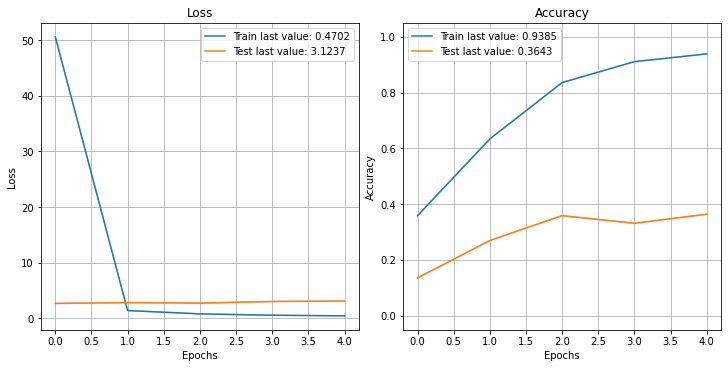

In [18]:
history = model.fit([X_train,X_train,X_train],y_train,epochs=5,validation_data=([X_test,X_test,X_test],y_test),batch_size=50)

loss, accuracy = model.evaluate([X_train,X_train,X_train],y_train, verbose=0)
print("Training Accuracy: {:.4f}".format(accuracy))
loss, accuracy = model.evaluate([X_test,X_test,X_test], y_test, verbose=0)
print("Testing Accuracy:  {:.4f}".format(accuracy))
plot_history(history)